ใน ep นี้ เราจะ

In [0]:
# URL
# https://github.com/gnoparus/bualabs/blob/master/nbs/03b-image-segmentation-siim-acr-pneumothorax-segmentation.ipynb

# 0. Install

เราจะต้อง Install kaggle เพื่อ Download Dataset

In [2]:
! curl -s https://course.fast.ai/setup/colab | bash
! pip install kaggle --upgrade
! pip install pydicom

Updating fastai...
Done.
Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.6)
     |████████████████████████████████| 7.1MB 2.8MB/s 


เช็ค GPU Memory

In [3]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7410 sha256=23e64548daf14c1df27197fd795fbed41b1168bc8e155fee0e4b532b90adb4d1
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.8 GB  | Proc size: 156.6 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


In [0]:
# !kill -9 -1

# 1. Import Library

Import pydicom สำหรับเปิดไฟล์ภาพเอ็กซ์เรย์ และ Libray อื่น ๆ ที่เราต้องการใช้

In [0]:
import math
import numpy as np
import pandas as pd

import os
import glob

import pydicom

from pathlib import Path
from matplotlib import cm
from matplotlib import pyplot as plt

import fastai
from fastai.vision import *

In [6]:
fastai.__version__

'1.0.59'

# 2. เตรียม Path สำหรับดาวน์โหลดข้อมูล

กำหนด path ของ Config File และ Dataset ว่าจะอยู่ใน Google Drive ถ้าเราใช้ [Google Colab](https://www.bualabs.com/archives/1687/what-is-colab-open-jupyter-notebook-in-github-on-google-colab-create-open-in-colab-button-colab-ep-1/) หรือ อยู่ใน HOME ถ้าเราใช้ VM ธรรมดา และกำหนด Environment Variable ไปยังโฟลเดอร์ที่เก็บ kaggle.json

ในกรณีใช้ Colab ให้ Mount Google Drive เพื่อดึง Config File มาจาก Google Drive ส่วนตัวของเรา เมื่อเรารัน Cell ด้านล่างจะมีลิงค์ปรากฎขึ้นมาให้เรา Login กด Approve แล้ว Copy Authorization Code มาใส่ในช่องด้านล่าง แล้วกด Enter

In [7]:
dataset = 'siim-acr-pneumothorax-segmentation'
dataset2 = 'jesperdramsch/siim-acr-pneumothorax-segmentation-data'
dataset3 = 'iafoss/siimacr-pneumothorax-segmentation-data-128'
dataset4 = 'iafoss/siimacr-pneumothorax-segmentation-data-256'
dataset5 = 'iafoss/siimacr-pneumothorax-segmentation-data-512'
dataset6 = 'iafoss/siimacr-pneumothorax-segmentation-data-1024'

dataset_test = 'ivanzhovannik/siim_stage2_png'

# Google Colab
config_path = Path('/content/drive')
data_path_base = Path('/content/datasets/')

data_path = data_path_base/dataset
data_path2 = data_path_base/dataset2
data_path3 = data_path_base/dataset3
data_path4 = data_path_base/dataset4
data_path5 = data_path_base/dataset5
data_path6 = data_path_base/dataset6
data_path_test = data_path_base/dataset_test

from google.colab import drive
drive.mount(str(config_path))
os.environ['KAGGLE_CONFIG_DIR'] = f"{config_path}/My Drive/.kaggle"

## VM
# config_path = Path(os.getenv("HOME"))
# data_path = config_path/"datasets"/dataset
# data_path2 = config_path/"datasets"/dataset2
# data_path3 = config_path/"datasets"/dataset3
# data_path4 = config_path/"datasets"/dataset4
# data_path5 = config_path/"datasets"/dataset5
# data_path6 = config_path/"datasets"/dataset6
# data_path_test = config_path/"datasets"/dataset_test

# data_path.mkdir(parents=True, exist_ok=True)
# os.environ['KAGGLE_CONFIG_DIR'] = f"{config_path}/.kaggle"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# 3. Dataset

ในเคสนี้ 

Dataset เราจะดึงจาก Kaggle วิธี Download kaggle.json ให้ดูจาก ep ที่แล้ว

เมื่อได้ kaggle.json มาแล้ว ในกรณีใช้ Google Colab ให้นำมาใส่ไว้ในโฟลเดอร์ My Drive/.kaggle ใน Google Drive ของเรา เป็น My Drive/.kaggle/kaggle.json ถ้าใช้ VM ให้ใส่ใน HOME/.kaggle/

สั่งดาวน์โหลด Dataset จาก Kaggle พร้อมทั้ง unzip ไว้ใน data_path

In [8]:
!kaggle competitions download -c {dataset} -p "{data_path}"
!kaggle datasets download {dataset2} -p "{data_path2}" --unzip
!kaggle datasets download {dataset3} -p "{data_path3}" --unzip
!kaggle datasets download {dataset4} -p "{data_path4}" --unzip
!kaggle datasets download {dataset5} -p "{data_path5}" --unzip
!kaggle datasets download {dataset6} -p "{data_path6}" --unzip
!kaggle datasets download {dataset_test} -p "{data_path_test}" --unzip

  0% 0.00/50.1k [00:00<?, ?B/s]
100% 50.1k/50.1k [00:00<00:00, 69.1MB/s]
 97% 399M/411M [00:03<00:00, 145MB/s]
100% 411M/411M [00:03<00:00, 121MB/s]
  0% 0.00/1.06M [00:00<?, ?B/s]
100% 1.06M/1.06M [00:00<00:00, 60.4MB/s]
  0% 0.00/3.61k [00:00<?, ?B/s]
100% 3.61k/3.61k [00:00<00:00, 3.07MB/s]
  0% 0.00/1.19k [00:00<?, ?B/s]
100% 1.19k/1.19k [00:00<00:00, 1.22MB/s]
100% 3.02G/3.03G [00:37<00:00, 120MB/s] 
100% 3.03G/3.03G [00:37<00:00, 86.0MB/s]
 95% 169M/178M [00:01<00:00, 98.4MB/s]
100% 178M/178M [00:01<00:00, 99.3MB/s]
 98% 610M/621M [00:06<00:00, 73.1MB/s]
100% 621M/621M [00:06<00:00, 95.1MB/s]
 99% 2.06G/2.08G [00:30<00:00, 85.9MB/s]
100% 2.08G/2.08G [00:30<00:00, 73.7MB/s]
100% 7.26G/7.26G [01:24<00:00, 65.5MB/s]
100% 7.26G/7.26G [01:24<00:00, 92.4MB/s]
100% 1.08G/1.08G [00:12<00:00, 77.1MB/s]
100% 1.08G/1.08G [00:12<00:00, 95.2MB/s]


In [0]:
# ! unzip -q {data_path}/stage_2_images.zip -d {data_path}/stage_2_images
# ! unzip -q {data_path}/stage_2_train.csv.zip -d {data_path}


import ฟังก์ชันสำหรับแปลง RLE to Mask ที่ให้มากับ Dataset

In [0]:
import sys
sys.path.insert(0, str(data_path))

from mask_functions import *

# 4. Data

## 4.1 DICOM Image

โหลดข้อมูลฟิล์มเอ็กซ์เรย์

In [0]:
def show_dcm_info(dataset):
    print("Filename.........:", file_path)
    print("Storage type.....:", dataset.SOPClassUID)
    print()

    pat_name = dataset.PatientName
    display_name = pat_name.family_name + ", " + pat_name.given_name
    print("Patient's name......:", display_name)
    print("Patient id..........:", dataset.PatientID)
    print("Patient's Age.......:", dataset.PatientAge)
    print("Patient's Sex.......:", dataset.PatientSex)
    print("Modality............:", dataset.Modality)
    print("Body Part Examined..:", dataset.BodyPartExamined)
    print("View Position.......:", dataset.ViewPosition)
    
    if 'PixelData' in dataset:
        rows = int(dataset.Rows)
        cols = int(dataset.Columns)
        print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
            rows=rows, cols=cols, size=len(dataset.PixelData)))
        if 'PixelSpacing' in dataset:
            print("Pixel spacing....:", dataset.PixelSpacing)

def plot_pixel_array(dataset, figsize=(10,10)):
    plt.figure(figsize=figsize)
    plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)
    plt.show()


Filename.........: /content/datasets/jesperdramsch/siim-acr-pneumothorax-segmentation-data/pneumothorax/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.4123.1517875181.220014/1.2.276.0.7230010.3.1.3.8323329.4123.1517875181.220013/1.2.276.0.7230010.3.1.4.8323329.4123.1517875181.220015.dcm
Storage type.....: 1.2.840.10008.5.1.4.1.1.7

Patient's name......: 57de852f-d19b-4002-9d7c-cbed6880a5f4, 
Patient id..........: 57de852f-d19b-4002-9d7c-cbed6880a5f4
Patient's Age.......: 62
Patient's Sex.......: M
Modality............: CR
Body Part Examined..: CHEST
View Position.......: AP
Image size.......: 1024 x 1024, 159176 bytes
Pixel spacing....: ['0.139', '0.139']


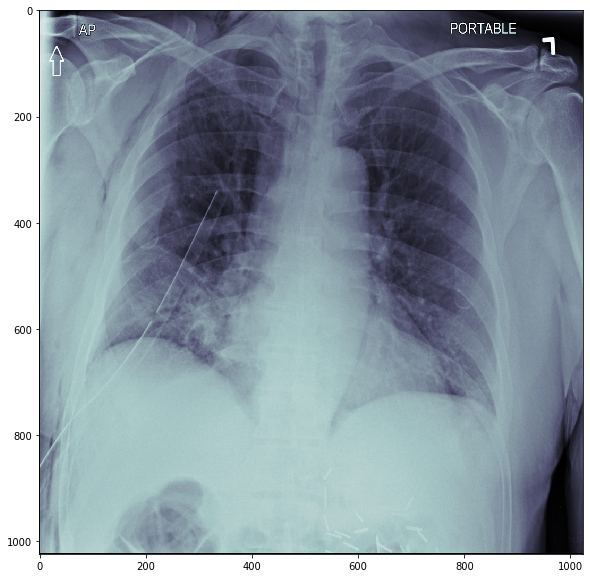

In [11]:
for file_path in glob.glob(str(data_path2/'pneumothorax/dicom-images-train/*/*/*.dcm')):
    dataset = pydicom.dcmread(file_path)
    show_dcm_info(dataset)
    plot_pixel_array(dataset)
    break # Comment this out to see all

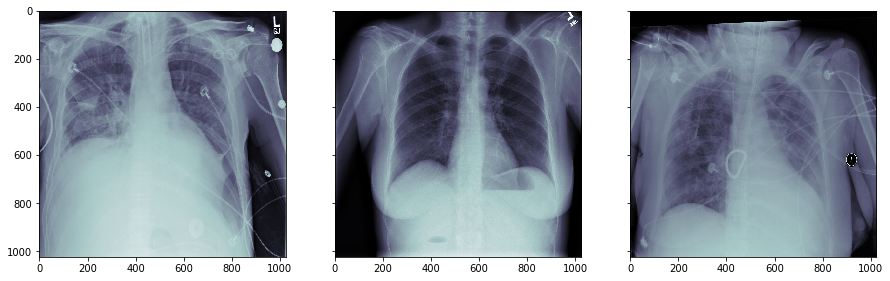

In [12]:
start = 55   # Starting index of images
num_img = 3 # Total number of images to show

fig, ax = plt.subplots(nrows=1, ncols=num_img, sharey=True, figsize=(num_img*5,5))
for q, file_path in enumerate(glob.glob(str(data_path2/'pneumothorax/dicom-images-train/*/*/*.dcm'))[start:start+num_img]):
    dataset = pydicom.dcmread(file_path)
    #show_dcm_info(dataset)
    
    ax[q].imshow(dataset.pixel_array, cmap=plt.cm.bone)


In [13]:
df = pd.read_csv(data_path2/'train-rle.csv', index_col=0)
df.head()

,EncodedPixels
ImageId,
1.2.276.0.7230010.3.1.4.8323329.5597.1517875188.959090,-1
1.2.276.0.7230010.3.1.4.8323329.12515.1517875239.501137,-1
1.2.276.0.7230010.3.1.4.8323329.4904.1517875185.355709,175349 7 1013 12 1009 17 1005 19 1003 20 1002...
1.2.276.0.7230010.3.1.4.8323329.32579.1517875161.299312,407576 2 1021 7 1015 10 1013 12 1011 14 1008 ...
1.2.276.0.7230010.3.1.4.8323329.32579.1517875161.299312,252069 1 1021 3 1020 4 1018 5 1018 6 1016 7 1...


In [14]:
df.shape

(11582, 1)

## 4.2 Mask

In [15]:
mask = rle2mask(df.loc['1.2.276.0.7230010.3.1.4.8323329.4904.1517875185.355709'][0].strip(), 1024, 1024).T
# a = mask.sum(axis=1)
# a = mask.sum(axis=0)
# a.argmax()

mask[105:115, 300:310]

array([[  0.,   0.,   0.,   0., ...,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0., ...,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0., ...,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0., ...,   0.,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0.,   0., ..., 255., 255., 255., 255.],
       [  0.,   0.,   0., 255., ..., 255., 255., 255., 255.],
       [  0., 255., 255., 255., ..., 255., 255., 255., 255.],
       [255., 255., 255., 255., ..., 255., 255., 255., 255.]])

In [16]:
mask_rgba = mask/255
mask_rgba = np.repeat(mask_rgba[:, :, np.newaxis], 4, axis=2)
mask_rgba[:, :, [1,2]] = 0
mask_rgba[:, :, 3] = mask_rgba[:, :, 3]*0.7

mask_rgba[105:115, 300:310, 0]

array([[0., 0., 0., 0., ..., 0., 0., 0., 0.],
       [0., 0., 0., 0., ..., 0., 0., 0., 0.],
       [0., 0., 0., 0., ..., 0., 0., 0., 0.],
       [0., 0., 0., 0., ..., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., ..., 1., 1., 1., 1.],
       [0., 0., 0., 1., ..., 1., 1., 1., 1.],
       [0., 1., 1., 1., ..., 1., 1., 1., 1.],
       [1., 1., 1., 1., ..., 1., 1., 1., 1.]])

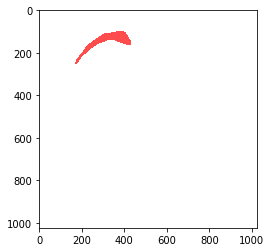

In [17]:
plt.imshow(mask_rgba)

## 4.3 DICOM Image and Mask

In [0]:
start = 52   # Starting index of images
num_img = 3 # Total number of images to show

1.2.276.0.7230010.3.1.4.8323329.12879.1517875242.339686.dcm
See Marker
1.2.276.0.7230010.3.1.4.8323329.32550.1517875161.142073.dcm
See Marker
1.2.276.0.7230010.3.1.4.8323329.14527.1517875252.540716.dcm
Nothing to see


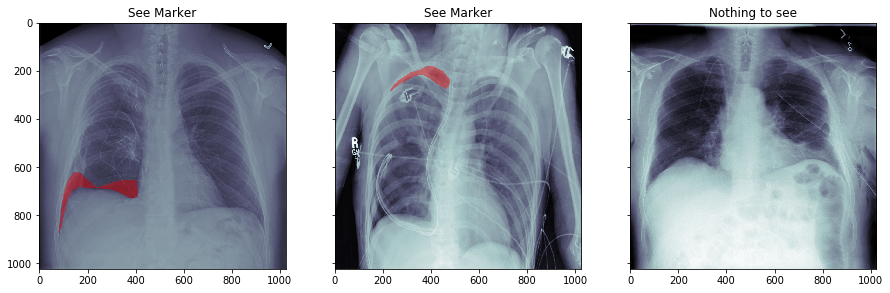

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=num_img, sharey=True, figsize=(num_img*5,5))
for q, file_path in enumerate(glob.glob(str(data_path2/'pneumothorax/dicom-images-train/*/*/*.dcm'))[start:start+num_img]):
    dataset = pydicom.dcmread(file_path)
    print(file_path.split('/')[-1])
    ax[q].imshow(dataset.pixel_array, cmap=plt.cm.bone)
    fn = file_path.split('/')[-1][:-4]
    rle = df.loc[fn][0].strip()
    # print(rle)
    if rle != '-1':
        print('See Marker')
        mask = rle2mask(rle, 1024, 1024).T
        ax[q].set_title('See Marker')
#         # Normal Mask
#         ax[q].imshow(mask, alpha=0.3, cmap="rainbow")
        
        # Make alpha mask
        mask_rgba = mask/255
        mask_rgba = np.repeat(mask_rgba[:, :, np.newaxis], 4, axis=2)
        mask_rgba[:, :, [1,2]] = 0
        mask_rgba[:, :, 3] = mask_rgba[:, :, 3]*0.4

        ax[q].imshow(mask_rgba)
    else:
        print('Nothing to see')
        ax[q].set_title('Nothing to see')


# 5. Data Pipeline

เมื่อเราได้รูปด้านบนมาแล้ว เพื่อความสำดวก เราจะแปลงทั้งหมดเป็นไฟล์รูป .png แล้ว Resize เป็นขนาดต่าง ๆ ใส่ไว้ใน Folder ที่กำหนด ซึ่งมีคนทำไว้ให้เราแล้ว เราก็ไป Download มาใน Dataset3 และ 4

In [0]:
bs=128

SZ = 128
path = data_path3

In [0]:
# Setting div=True in open_mask
class SegmentationLabelList(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)
    
class SegmentationItemList(SegmentationItemList):
    _label_cls = SegmentationLabelList

# Setting transformations on masks to False on test set
def transform(self, tfms:Optional[Tuple[TfmList,TfmList]]=(None,None), **kwargs):
    if not tfms: tfms=(None,None)
    assert is_listy(tfms) and len(tfms) == 2
    self.train.transform(tfms[0], **kwargs)
    self.valid.transform(tfms[1], **kwargs)
    kwargs['tfm_y'] = False # Test data has no labels
    if self.test: self.test.transform(tfms[1], **kwargs)
    return self
fastai.data_block.ItemLists.transform = transform

In [0]:
# Create databunch
data = (SegmentationItemList.from_folder(path=path/'train')#[:500]
        .split_by_rand_pct(0.2, seed=1234)
        .label_from_func(lambda x : str(x).replace('train', 'masks'), classes=[0, 1])
        # .add_test((path/'test').ls(), label=None)
        .add_test((data_path_test).ls(), label=None)
        .transform(get_transforms(), size=SZ, tfm_y=True)
        .databunch(path=Path('.'), bs=bs)
        .normalize(imagenet_stats))

In [23]:
len(data.train_ds), len(data.valid_ds)

(9638, 2409)

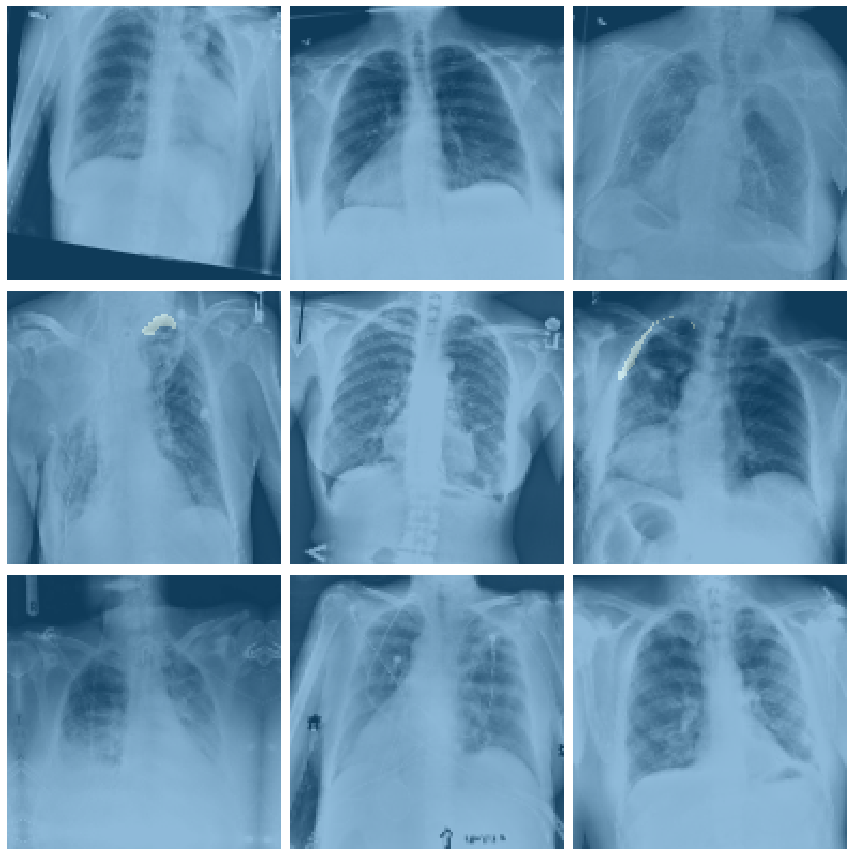

In [24]:
data.show_batch(rows=3, figsize=(12, 12))

# 6. Model

## 6.1 U-Net and ResNet

## 6.2 Dice Metric

In [0]:
# dice??

In [26]:
learn = unet_learner(data, models.resnet34, metrics=[dice], self_attention=True, 
                     blur=True, norm_type=NormType.Weight, 
                     callback_fns=ShowGraph).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:03<00:00, 23.4MB/s]


In [0]:
# learn.summary()

# 7. Train

In [0]:
# learn.lr_find()
# learn.recorder.plot(suggestion=True, skip_last=1)

## 7.1 Train Last Layer

In [0]:
lr = 1e-3

epoch,train_loss,valid_loss,dice,time
0,0.030818,0.017970,0.792445,05:00
1,0.020003,0.014822,0.792445,03:53
2,0.015467,0.012819,0.791617,03:54


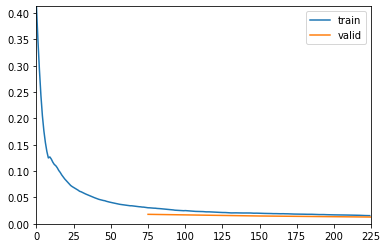

In [30]:
learn.fit_one_cycle(3, max_lr=lr, wd=1e-3, pct_start=0.8)

In [0]:
learn.save('03b-unet-resnet34-128-1')

In [0]:
learn.load('03b-unet-resnet34-128-1');

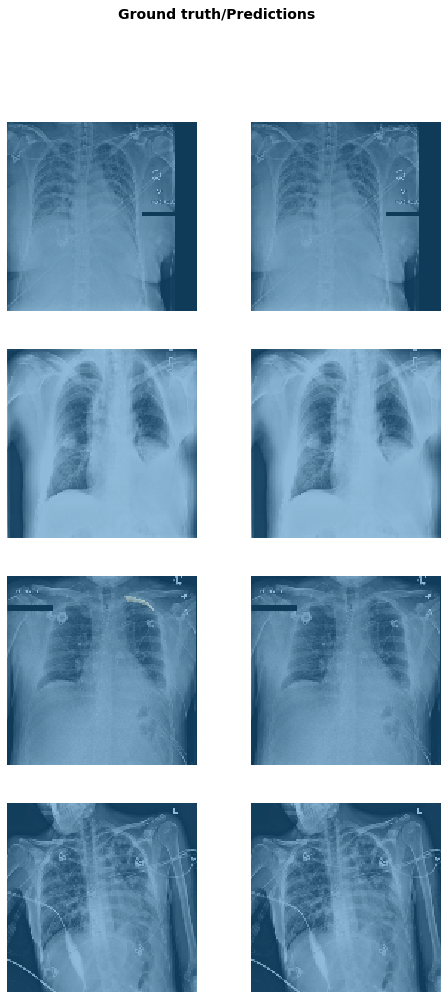

In [33]:
learn.show_results(rows=4, figsize=(8, 16))

## 7.2 Unfreeze and Train Whole Model

In [0]:
learn.unfreeze()

In [0]:
# learn.lr_find()
# learn.recorder.plot(suggestion=True, skip_last=0)

In [0]:
lr = slice(3e-6, 3e-4)

epoch,train_loss,valid_loss,dice,time
0,0.013152,0.012453,0.783090,04:04
1,0.013060,0.012565,0.729400,04:03
2,0.012830,0.011784,0.756669,04:03
3,0.012293,0.011422,0.742016,04:03
4,0.011766,0.012540,0.663081,04:02
5,0.011273,0.012753,0.792137,04:02
6,0.010988,0.011656,0.792288,04:02
7,0.010082,0.010386,0.787501,03:58


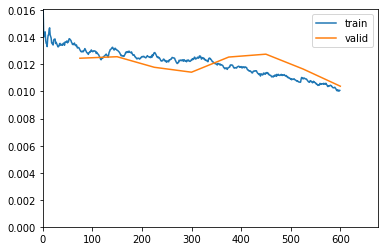

In [0]:
learn.fit_one_cycle(9, max_lr=lr, wd=1e-3, pct_start=0.7)

In [0]:
learn.save('03b-unet-resnet34-128-2')

In [0]:
learn.load('03b-unet-resnet34-128-2');

In [0]:
learn.show_results(rows=4, figsize=(8, 16))

## 7.3 Increase Image size to 256 and Train Last Layer

In [0]:
learn.destroy()
gc.collect()

In [0]:
bs=64

SZ = 256
path = data_path4

In [0]:
# Create databunch
data = (SegmentationItemList.from_folder(path=path/'train')#[:500]
        .split_by_rand_pct(0.2, seed=1234)
        .label_from_func(lambda x : str(x).replace('train', 'masks'), classes=[0, 1])
        # .add_test((path/'test').ls(), label=None)
        .add_test((data_path_test).ls(), label=None)
        .transform(get_transforms(), size=SZ, tfm_y=True)
        .databunch(path=Path('.'), bs=bs)
        .normalize())

In [0]:
learn = unet_learner(data, models.resnet34, metrics=[dice], 
                     self_attention=True, blur=True, norm_type=NormType.Weight, 
                     callback_fns=ShowGraph).to_fp16()

In [0]:
learn.load('03b-unet-resnet34-128-2')
learn.freeze()

In [0]:
# learn.lr_find()
# learn.recorder.plot(suggestion=True, skip_last=1)

In [0]:
lr = 3e-4

In [0]:
learn.fit_one_cycle(4, max_lr=lr, wd=1e-3, pct_start=0.8)

In [0]:
learn.save('03b-unet-resnet34-256-1')

In [0]:
learn.load('03b-unet-resnet34-256-1');

In [0]:
learn.show_results(rows=4, figsize=(8, 16))

## 7.4 Unfreeze and Train Whole Model with 256

In [0]:
learn.unfreeze()

In [0]:
# learn.lr_find()
# learn.recorder.plot(suggestion=True, skip_last=0)

In [0]:
lr = slice(3e-6, 1e-4)

In [0]:
learn.fit_one_cycle(10, max_lr=lr, wd=1e-3, pct_start=0.7)

In [0]:
learn.save('03b-unet-resnet34-256-2')

In [0]:
learn.load('03b-unet-resnet34-256-2');

In [0]:
learn.show_results(rows=4, figsize=(8, 16))

## 7.5 Increase Image size to 512 and Train Last Layer

In [86]:
learn.destroy()
gc.collect()

this Learner object self-destroyed - it still exists, but no longer usable


0

In [0]:
bs=8

SZ = 512
path = data_path5

In [0]:
# path.ls()

In [0]:
# Create databunch
data = (SegmentationItemList.from_folder(path=path/'train')#[:500]
        .split_by_rand_pct(0.2, seed=1234)
        .label_from_func(lambda x : str(x).replace('train', 'masks'), classes=[0, 1])
        # .add_test((path/'test').ls(), label=None)
        .add_test((data_path_test).ls(), label=None)
        .transform(get_transforms(), size=SZ, tfm_y=True)
        .databunch(path=Path('.'), bs=bs)
        .normalize())

In [0]:
learn = unet_learner(data, models.resnet34, metrics=[dice], self_attention=True, blur=True, norm_type=NormType.Weight, callback_fns=ShowGraph).to_fp16()

In [0]:
learn.load('03b-unet-resnet34-256-2')
learn.freeze()

In [0]:
# learn.lr_find()
# learn.recorder.plot(suggestion=True, skip_last=1)

In [0]:
lr = 3e-4

epoch,train_loss,valid_loss,dice,time
0,0.011542,0.009669,0.786302,20:17
1,0.009844,0.010386,0.798099,20:12
2,0.009379,0.008417,0.808897,20:07
3,0.008040,0.007762,0.805745,20:04


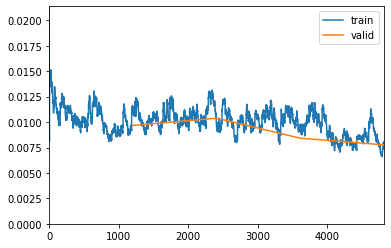

In [102]:
learn.fit_one_cycle(4, max_lr=lr, wd=1e-3, pct_start=0.8)

In [0]:
learn.save('03b-unet-resnet34-512-1')

In [0]:
learn.load('03b-unet-resnet34-512-1');

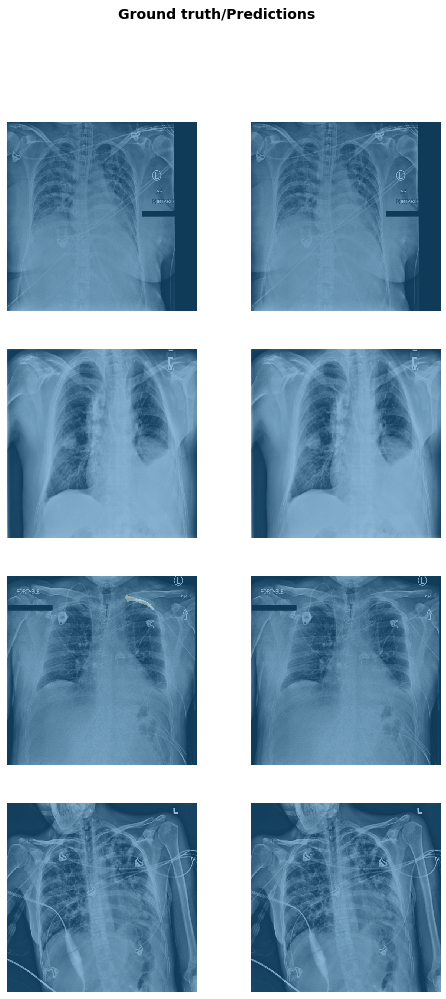

In [105]:
learn.show_results(rows=4, figsize=(8, 16))

## 7.4 Unfreeze and Train Whole Model with 512

In [0]:
learn.unfreeze()

In [0]:
# learn.lr_find()
# learn.recorder.plot(suggestion=True, skip_last=0)

In [0]:
lr = slice(3e-6, 1e-4)

In [0]:
learn.fit_one_cycle(8, max_lr=lr, wd=1e-3, pct_start=0.7)

epoch,train_loss,valid_loss,dice,time


In [0]:
learn.save('03b-unet-resnet34-512-2')

In [0]:
learn.load('03b-unet-resnet34-512-2');

In [0]:
learn.show_results(rows=4, figsize=(8, 16))

## 7.5 Increase Image size to 1024 and Train Last Layer

In [459]:
learn.destroy()

this Learner object self-destroyed - it still exists, but no longer usable


In [0]:
bs=8

SZ = 1024
path = data_path6

In [0]:
# path.ls()

In [0]:
# Create databunch
data = (SegmentationItemList.from_folder(path=path/'train')#[:500]
        .split_by_rand_pct(0.2, seed=1234)
        .label_from_func(lambda x : str(x).replace('train', 'masks'), classes=[0, 1])
        # .add_test((path/'test').ls(), label=None)
        .add_test((data_path_test).ls(), label=None)
        .transform(get_transforms(), size=SZ, tfm_y=True)
        .databunch(path=Path('.'), bs=bs)
        .normalize())

In [0]:
learn = unet_learner(data, models.resnet34, metrics=[dice], self_attention=True, blur=True, norm_type=NormType.Weight, callback_fns=ShowGraph).to_fp16()

In [0]:
learn.load('03b-unet-resnet34-512-2')
learn.freeze()

In [0]:
# learn.lr_find()
# learn.recorder.plot(suggestion=True, skip_last=1)

In [0]:
lr = 3e-4

In [0]:
learn.fit_one_cycle(6, max_lr=lr, wd=1e-3, pct_start=0.8)

epoch,train_loss,valid_loss,dice,time


In [0]:
learn.save('03b-unet-resnet34-1024-1')

In [0]:
learn.load('03b-unet-resnet34-1024-1');

In [0]:
learn.show_results(rows=4, figsize=(8, 16))

## 7.4 Unfreeze and Train Whole Model with 1024

In [0]:
learn.unfreeze()

In [0]:
# learn.lr_find()
# learn.recorder.plot(suggestion=True, skip_last=0)

In [0]:
lr = slice(3e-6, 1e-4)

epoch,train_loss,valid_loss,dice,time
0,0.008442,0.009092,0.779975,04:24
1,0.009186,0.009070,0.784404,04:24
2,0.008529,0.008767,0.781244,04:24
3,0.009220,0.008640,0.785985,04:24
4,0.008483,0.009765,0.794576,04:24
5,0.008025,0.008653,0.772431,04:25
6,0.008657,0.008764,0.794828,04:24
7,0.008019,0.008418,0.788234,04:24
8,0.007101,0.008586,0.786627,04:24
9,0.006501,0.008913,0.791181,04:24


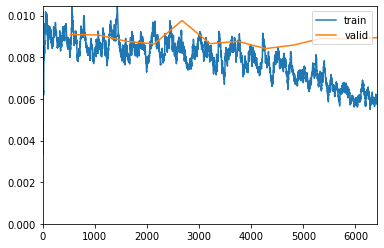

In [0]:
learn.fit_one_cycle(12, max_lr=lr, wd=1e-3, pct_start=0.7)

In [0]:
learn.save('03b-unet-resnet34-1024-2')

In [0]:
learn.load('03b-unet-resnet34-1024-2');

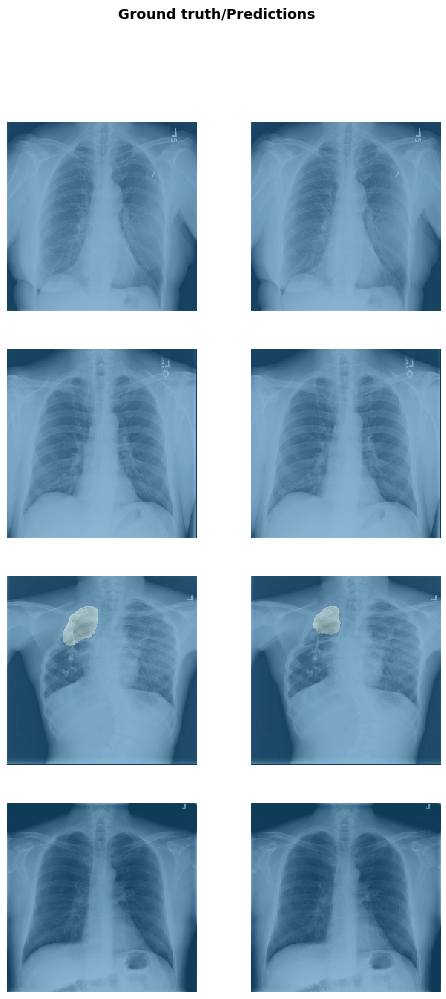

In [0]:
learn.show_results(rows=4, figsize=(8, 16))

# 8. Make a Prediction

In [0]:
# Predictions for the validation set
preds, ys = learn.get_preds()
preds = preds[:,1,...]
ys = ys.squeeze()

In [291]:
preds.shape, ys.shape

(torch.Size([2142, 256, 256]), torch.Size([2142, 256, 256]))

In [0]:
def dice_overall(preds, targs):
    n = preds.shape[0]
    preds = preds.view(n, -1)
    targs = targs.view(n, -1)
    intersect = (preds * targs).sum(-1).float()
    union = (preds+targs).sum(-1).float()
    u0 = union==0
    intersect[u0] = 1
    union[u0] = 2
    return (2. * intersect / union)

In [293]:
# Find optimal threshold
dices = []
thrs = np.arange(0.01, 1, 0.01)
for i in progress_bar(thrs):
    preds_m = (preds>i).long()
    dices.append(dice_overall(preds_m, ys).mean())
dices = np.array(dices)

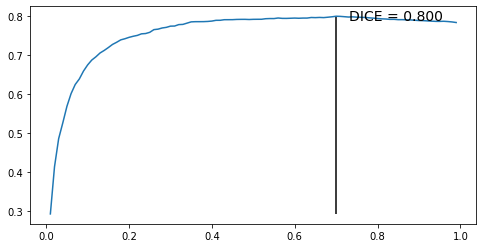

In [294]:
best_dice = dices.max()
best_thr = thrs[dices.argmax()]

plt.figure(figsize=(8,4))
plt.plot(thrs, dices)
plt.vlines(x=best_thr, ymin=dices.min(), ymax=dices.max())
plt.text(best_thr+0.03, best_dice-0.01, f'DICE = {best_dice:.3f}', fontsize=14);
plt.show()

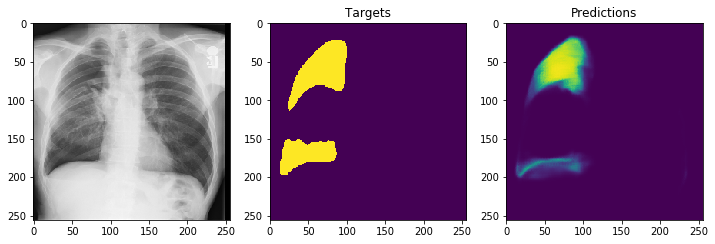

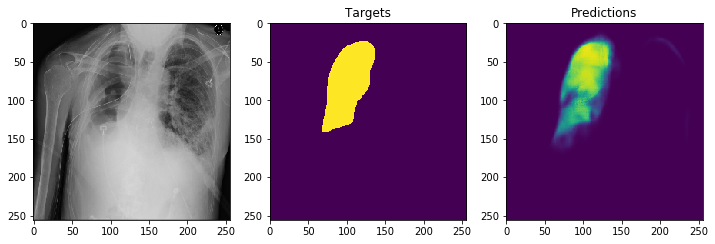

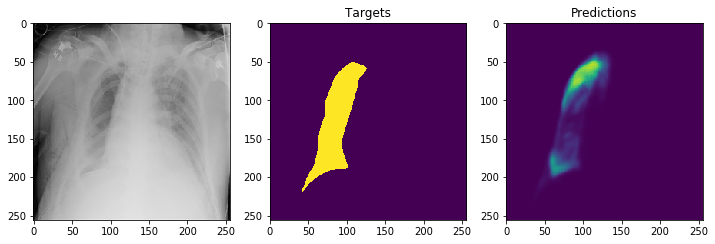

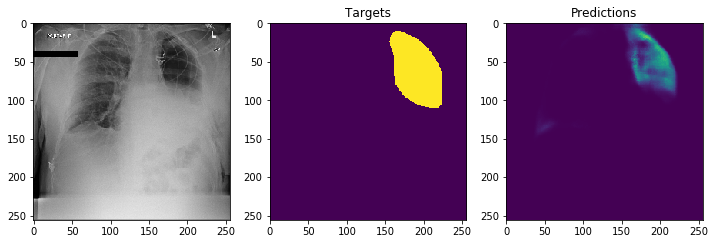

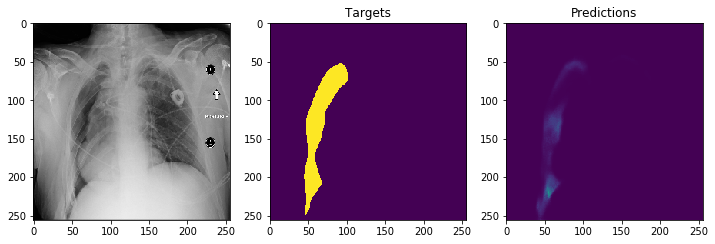

In [295]:
# Plot some samples
rows = 5
plot_idx = ys.sum((1,2)).sort(descending=True).indices[:rows]
for idx in plot_idx:
    fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(12, 4))
    ax0.imshow(data.valid_ds[idx][0].data.numpy().transpose(1,2,0))
    ax1.imshow(ys[idx], vmin=0, vmax=1)
    ax2.imshow(preds[idx], vmin=0, vmax=1)
    ax1.set_title('Targets')
    ax2.set_title('Predictions')

# 10. Submit Predictions to Kaggle Competitiion

In [296]:
# Predictions for test set
preds, _ = learn.get_preds(ds_type=DatasetType.Test)
preds = (preds[:,1,...]>best_thr).long().numpy()
print(preds.sum())

165464


In [297]:
# Generate rle encodings (images are first converted to the original size)
rles = []
for p in progress_bar(preds):
    im = PIL.Image.fromarray((p.T*255).astype(np.uint8)).resize((1024,1024))
    im = np.asarray(im)
    rles.append(mask2rle(im, 1024, 1024))

In [298]:
ids = [o.stem for o in data.test_ds.items]
sub_df = pd.DataFrame({'ImageId': ids, 'EncodedPixels': rles})
sub_df.loc[sub_df.EncodedPixels=='', 'EncodedPixels'] = '-1'
sub_df.head()

,ImageId,EncodedPixels
0,ID_55013ddec,-1
1,ID_b8de09574,-1
2,ID_53892d3d0,307376 4 1020 4 1020 4 1020 4 1012 8 1016 8 10...
3,ID_46bc482f7,-1
4,ID_40597db0e,-1


In [299]:
sub_df.shape

(3205, 2)

In [0]:
sub_df.to_csv('submission.csv', index=False)

In [301]:
! kaggle competitions submit siim-acr-pneumothorax-segmentation -f {'submission.csv'} -m "My submission"

100% 361k/361k [00:02<00:00, 131kB/s]
Successfully submitted to SIIM-ACR Pneumothorax Segmentation

# Credit

* https://www.kaggle.com/c/siim-acr-pneumothorax-segmentation/
* https://www.bualabs.com/archives/835/image-segmentation-semantic-segmentation-camvid-machine-learning-unet-deep-learning-image-segmentation-ep-1/
* https://en.wikipedia.org/wiki/Pneumothorax
* https://www.kaggle.com/schlerp/getting-to-know-dicom-and-the-data/
* https://www.kaggle.com/jesperdramsch/intro-chest-xray-dicom-viz-u-nets-full-data
* https://www.kaggle.com/jesperdramsch/siim-acr-pneumothorax-segmentation-data
* https://www.kaggle.com/iafoss/hypercolumns-pneumothorax-fastai-0-831-lb
* https://www.kaggle.com/iafoss/siimacr-pneumothorax-segmentation-data-128
* https://www.kaggle.com/iafoss/siimacr-pneumothorax-segmentation-data-256
* https://www.kaggle.com/iafoss/siimacr-pneumothorax-segmentation-data-512
* https://www.kaggle.com/iafoss/siimacr-pneumothorax-segmentation-data-1024
* https://www.kaggle.com/mnpinto/pneumothorax-fastai-u-net
* https://www.kaggle.com/c/rsna-pneumonia-detection-challenge
* https://www.kaggle.com/meaninglesslives/unet-with-efficientnet-encoder-in-keras
* https://pydicom.github.io/pydicom/stable/getting_started.html
* https://docs.python.org/2/library/glob.html
* https://arxiv.org/abs/1505.04597
